含并行连结的网络 GoogLeNet
- 第一个卷积神经网络可以做到100层
- 最好的卷积层超参数？
- Inception块：小学生才做选择题，我全都要了
- 4个路径从不同层面抽取信息，然后在输出通道维合并
- 使用不同窗口大小的卷积层，使用池化层，跟输入等同高宽
- input并联 1x1 Conv / 1x1 Conv -> 3x3 Conv pad 1 / 1x1 Conv -> 5x5 Conv pad 2 / 3x3 MaxPool pad 1 -> 1x1 Conv  ----> Concatenation
- 输入先接入到一个1x1的卷积层里面
- 第二条路先通过1x1的卷积层对通道做变换，再输入到3x3的卷积层， pad=1使得输入输出高宽相等
- 第三条路又是一个1x1的卷积层对通道数做变换，不改变高宽，再输入到5x5的卷积层来获取空间信息，pad=2使得输入输出高宽相等
- 第四条路用了一个3x3的最大池化层，pad=1，再加1x1的卷积层
- 所有四条路都没改变高宽，在concatenation层把他们合并起来
- 怎么合并呢？在输出的通道数上做合并！不是放一个更大的图片，输出不改变高宽，通道数会变得非常多，是四条路的通道数并到一起
- 高宽不变--变得是通道数

Inception块
- 降低通道数来控制模型复杂度
- 每条路上通道数可能不同
- Max pooling不会改变通道数
- input(192x28x28) ----> (64) 1x1 Conv / (96) 1x1 Conv -> (128) 3x3 Conv pad 1 / (16) 1x1 Conv -> (32) 5x5 Conv pad 2 / 3x3 MaxPool pad 1 -> (32) 1x1 Conv  ----> Concatenation
- 2-3路的1x1 Conv都是用来变换通道数的，其他的卷积层是用来抽取信息的
- 最后的通道数是256，那么把256分成了128，64，32，32
- 跟单3x3或5x5卷积层比，Inception块有更少的参数个数和计算复杂度
- Inception 0.16M param, 128M FLOPS; 3x3 Conv 0.44M, 346M; 5x5 Conv 1.22M, 963M

GoogLeNet
- 5段，9个Inception块
- stage 1: 7x7 Conv -> 3x3 MaxPool
- stage 2: 1x1 Conv -> 3x3 Conv -> 3x3 MaxPool  用来中间觉得最重要的这条道路
- stage 3: Inception block x 2 -> 3x3 MaxPool Stride 2
- stage 4: Inception block x 5 -> 3x3 MaxPool
- stage 5: Inception block x 2 -> Global AvgPool
- FC: 最后拿到Fully Connected layer，通过全连接层映射到类别
- 把高宽减半叫做一个stage
- 因为inception不改变高宽，只改变通道数，用3x3 MaxPool Stride 2来高宽减半
- GoogLeNet大量使用了1x1卷积，也使用Global AvgPool

Stage 1 & 2
- 更小的宽口，更多的通道
- GoogLeNet: 3x224x224 -> 7x7 Conv (64) stride 2 pad 3 -> 3x3 MaxPool stride 2 pad 1 -> 1x1 Conv (64) -> 3x3 Conv (192) pad 1 -> 3x3 MaxPool stride 2 pad 1 -> 192x28x28
- AlexNet: 3x224x224 -> 11x11 Conv (96) stride 4 -> 3x3 MaxPool stide 2 -> 5x5 Conv (256) pad 2 -> 3x3 MaxPool stride 2 -> 256x12x12

Stage 3
- 通道分配不同，输出通道增加
- input(192x28x28) ----> 1x1 Conv (64) / 1x1 Conv (96) -> 3x3 Conv (128) pad 1 / 1x1 Conv (16) -> 5x5 Conv (32) pad 2 / 3x3 MaxPool pad 1 -> 1x1 Conv (32) ---> Concatenation (256)
- input(256) ----> 1x1 Conv (128) / 1x1 Conv (128) -> 3x3 Conv (192) pad 1 / 1x1 Conv (32) -> 5x5 Conv (96) pad 2 / 3x3 MaxPool pad 1 -> 1x1 Conv (64) ---> Concatenation (480) ---> 3x3 MaxPool stride 2 pad 1 ---> 480x14x14

Stage 4 & 5
- 增加通道数，1024维特征输出
- 480x14x14 -> 4 Inception block (512) -> Inception block (832) -> 3x3 MaxPool stride 2 pad 1 -> 832x7x7
- 832x7x7 -> Inception block (832) -> Inception block (1024) -> Global AvgPool -> 1024x1x1

Inception有各种后续变种
- 上述介绍的是v1
- Inception-BN (v2) - 使用batch normalization
- Inception-V3 - 修改了Inception块
- 替换5x5为多个3x3卷积层
- 替换5x5为1x7和7x1卷积层 -- 先在行上面看空间信息列先不看，先在列上面看空间信息行先不看
- 替换3x3为1x3和3x1卷积层
- 更深
- Inception-V4 - 使用残差连接 residual connection
- V3和V4用的比较多

总结
- Inception块用4条有不同超参数的卷积层和池化层的路来抽取不同的信息，它的一个主要优点是模型参数小，计算复杂度低
- GoogLeNet使用了9个Inception块，是第一个达到上百层的网络，后续有一系列改进
- 纯深100直到resnet的出现


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install d2l==0.17.6

In [ ]:
import os
path = '/content/drive/MyDrive'
os.chdir(path)

!source venv_d2l/bin/activate

path = '/content/drive/MyDrive/d2l-zh'
os.chdir(path)

In [ ]:
# Inception块

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 自定义类实现Inception Block
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数。设置每一条path里的channel数
    # c2就是一个tuple
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
# 四个stage
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
# 为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.240, train acc 0.909, test acc 0.901
1374.1 examples/sec on cuda:0


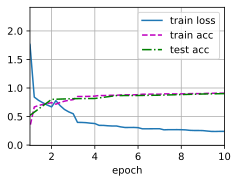

In [ ]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

QA
- 第四条路径的MaxPool是作用在前面卷积层的输出上，相当于卷积层的作用，后面的1x1Conv相当于全连接层，就是降低通道数用的。
- 1x1Conv用来降低复杂度，2^n在GPU上算得快一些
- 深度学习尽量不要调整网络的结构，可以调整通道数